## Libraries

`torchvision.datasets` contains some popular datasets for computer vision.

`torchvision.models` contains some popular architectures for computer vision.

`torchvision.transforms` contains common image transformations.

`torch.utils.data.Dataset` is an abstract class representing a dataset.

`torch.utils.data.DataLoader` wraps a dataset and provides access to the underlying data.

In [102]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2


## import dataset

In [103]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)

print(len(train_data))
print(len(test_data))

60000
10000


In [104]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [105]:
class_to_idx = train_data.class_to_idx
print(class_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [106]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [107]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

## Visualizing data

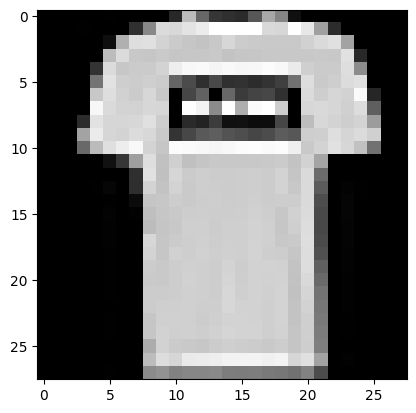

In [108]:
image, label = train_data[1]
plt.imshow(image.squeeze(), cmap="gray")

## Dataloaders

turns the data into an iterable object

In [109]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_dataloader), len(test_dataloader))

1875 313


In [110]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape, train_labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


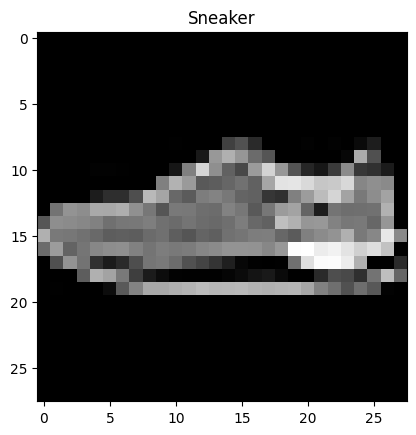

In [111]:
random_idx = torch.randint(0, len(train_features), (1,)).item()
img, label = train_features[random_idx], train_labels[random_idx]
plt.title(class_names[label]) 
plt.imshow(img.squeeze(), cmap="gray")

## Building the model

In [112]:
flatten_model = nn.Flatten()

x = train_features[0]

op = flatten_model(x)
op.shape

torch.Size([1, 784])

In [113]:
class CVModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

model = CVModel(28*28, 10, len(class_names))
model

CVModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Loss function, optimizer and evaluation metrics

In [114]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names))

In [115]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float):
    total_time = end - start
    print(f"Total Time: {total_time:.3f}s")
    return total_time


## Training Loop

In [116]:
from tqdm.auto import tqdm   # for progress bar

torch.manual_seed(42)
train_time_start = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)  # find average train_loss per batch for that particular epochs
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss +=  loss
            test_acc += accuracy(test_pred, y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\n Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}")

train_time_end = timer()

total_train_time = print_train_time(train_time_start, train_time_end)

 


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]


 Train Loss: 0.59 | Train Acc: 0.79 | Test Loss: 0.51 | Test Acc: 0.82
Epoch: 1
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 40%|████      | 2/5 [00:07<00:11,  3.75s/it]


 Train Loss: 0.48 | Train Acc: 0.83 | Test Loss: 0.50 | Test Acc: 0.83
Epoch: 2
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:11<00:07,  3.75s/it]


 Train Loss: 0.46 | Train Acc: 0.84 | Test Loss: 0.48 | Test Acc: 0.83
Epoch: 3
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 80%|████████  | 4/5 [00:15<00:03,  3.79s/it]


 Train Loss: 0.44 | Train Acc: 0.84 | Test Loss: 0.46 | Test Acc: 0.84
Epoch: 4
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


 Train Loss: 0.44 | Train Acc: 0.85 | Test Loss: 0.47 | Test Acc: 0.83
Total Time: 18.966s
